In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import os
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import psutil
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, f1_score  
from keras.layers import BatchNormalization
import torch
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim

# Data Loading and Preprocessing

In [2]:
# set global parameters
num_epochs = 50
learning_rate = 0.001

In [3]:
train_dir = r'C:\UM\Y2S2\WIX 3001 SOFT COMPUTING\Assignments\Group Assignment 2\BoneFractureDataset\training'
test_dir = r'C:\UM\Y2S2\WIX 3001 SOFT COMPUTING\Assignments\Group Assignment 2\BoneFractureDataset\testing'

In [4]:
# Initialize ImageDataGenerator for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotation angle range
    width_shift_range=0.2,  # Horizontal shift range
    height_shift_range=0.2,  # Vertical shift range
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Random zoom range
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,  # Do not flip images vertically
)

test_datagen = ImageDataGenerator(rescale=1./255) 


In [5]:
batch_size = 64
target_size = (128, 128)

# Load training images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary', 
)


# Load testing images
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary' 
)

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [6]:
# Get class indices
class_indices = train_generator.class_indices

# Get class counts
class_counts = train_generator.classes

# Convert class indices to class names
class_names = list(class_indices.keys())

# Count the number of samples for each class
counts_per_class = {class_names[i]: list(class_counts).count(i) for i in range(len(class_names))}

# Print class counts
print("Check Class Count in Training Set")
print("------------------------------------")

for class_name, count in counts_per_class.items():
    print(f"{class_name}: {count} samples")

Check Class Count in Training Set
------------------------------------
fractured: 4480 samples
not_fractured: 4383 samples


In [7]:
# Assuming train_generator is your train generator
batch_images, batch_labels = train_generator.next()

# Check the shape of the images in the batch
print("Shape of batch images:", batch_images.shape)


Shape of batch images: (64, 128, 128, 3)


In [8]:
# Get class indices
class_indices = test_generator.class_indices

# Get class counts
class_counts = test_generator.classes

# Convert class indices to class names
class_names = list(class_indices.keys())

# Count the number of samples for each class
counts_per_class = {class_names[i]: list(class_counts).count(i) for i in range(len(class_names))}

# Print class counts
print("Check Class Count in Testing Set")
print("------------------------------------")

for class_name, count in counts_per_class.items():
    print(f"{class_name}: {count} samples")

Check Class Count in Testing Set
------------------------------------
fractured: 360 samples
not_fractured: 240 samples


In [9]:
batch_images, batch_labels = test_generator.next()

# Check the shape of the images in the batch
print("Shape of batch images:", batch_images.shape)


Shape of batch images: (64, 128, 128, 3)


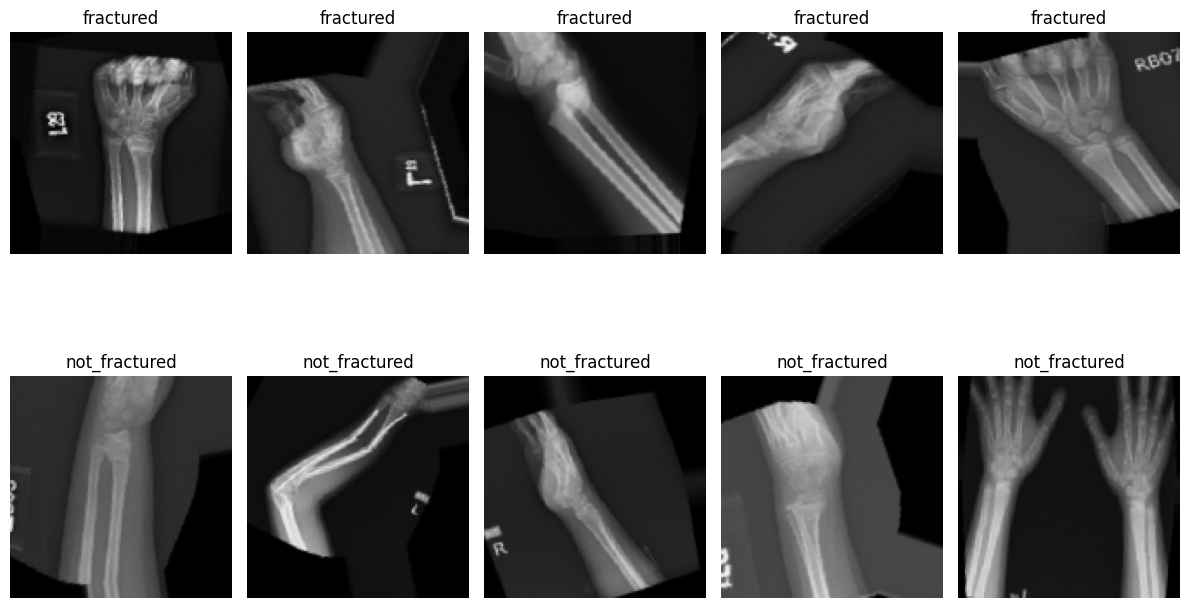

In [10]:
# Visualize sample images from the training set
plt.figure(figsize=(12, 8))

for class_index, class_name in enumerate(train_generator.class_indices):
    class_images = train_generator.next()[0][:5]  
    # Plot the images
    for i, image in enumerate(class_images):
        # Determine the row position based on class index
        row_position = i if class_index == 0 else i + 5
        plt.subplot(2, 5, row_position + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()


## CPU and RAM used tracking

In [11]:
# Function to start time tracking
def start_timer():
    return time.time()

# Function to stop time tracking and calculate duration
def stop_timer(start_time):
    return time.time() - start_time

# Function to monitor CPU and RAM usage
def monitor_resources():
    cpu_percent = psutil.cpu_percent()
    ram_percent = psutil.virtual_memory().percent
    return cpu_percent,ram_percent


Since we are running Jupyter Notebook on a local machine and have not explicitly configured it to use a GPU, then by default, it will use CPU for computations ,so GPU tracking is excluded.

# CNN Architechture Design and Development

## TensorFlow Model 1

In [12]:
model_tf1 = k.models.Sequential([
    k.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),  
    k.layers.MaxPooling2D((2, 2)),
    k.layers.Flatten(),
    k.layers.Dense(1, activation='sigmoid')  
])

optimizer = k.optimizers.Adam(learning_rate=learning_rate)
loss = k.losses.BinaryCrossentropy()

model_tf1.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

In [13]:
model_tf1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 63504)             0         
                                                                 
 dense (Dense)               (None, 1)                 63505     
                                                                 
Total params: 63953 (249.82 KB)
Trainable params: 63953 (249.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Start time tracking
start_time_tf1 = start_timer()

# Train the model
history_tf1 = model_tf1.fit(train_generator, epochs=num_epochs, validation_data=test_generator)

# Stop time tracking
duration_tf1 = stop_timer(start_time_tf1)

# Calculate CPU and RAM usage
cpu_usage_tf1, ram_usage_tf1 = monitor_resources()

Epoch 1/50


139/139 [==============================] - 38s 265ms/step - loss: 0.7108 - accuracy: 0.5505 - val_loss: 0.6795 - val_accuracy: 0.5350
Epoch 2/50
139/139 [==============================] - 32s 227ms/step - loss: 0.6711 - accuracy: 0.5780 - val_loss: 0.6341 - val_accuracy: 0.5683
Epoch 3/50
139/139 [==============================] - 31s 224ms/step - loss: 0.6622 - accuracy: 0.5864 - val_loss: 0.6452 - val_accuracy: 0.5167
Epoch 4/50
139/139 [==============================] - 32s 231ms/step - loss: 0.6604 - accuracy: 0.5935 - val_loss: 0.6654 - val_accuracy: 0.5817
Epoch 5/50
139/139 [==============================] - 31s 226ms/step - loss: 0.6577 - accuracy: 0.6030 - val_loss: 0.6163 - val_accuracy: 0.6200
Epoch 6/50
139/139 [==============================] - 31s 226ms/step - loss: 0.6590 - accuracy: 0.6002 - val_loss: 0.6205 - val_accuracy: 0.5617
Epoch 7/50
139/139 [==============================] - 32s 231ms/step - loss: 0.6586 - accuracy: 0.5987 - val_loss: 0.6290 - val_

In [15]:
# Print training duration and resource usage
print("Training Duration:", duration_tf1, "seconds")
print("CPU Usage:", cpu_usage_tf1, "%")
print("RAM Usage:",ram_usage_tf1,"%")

Training Duration: 1576.3590619564056 seconds
CPU Usage: 8.0 %
RAM Usage: 49.6 %


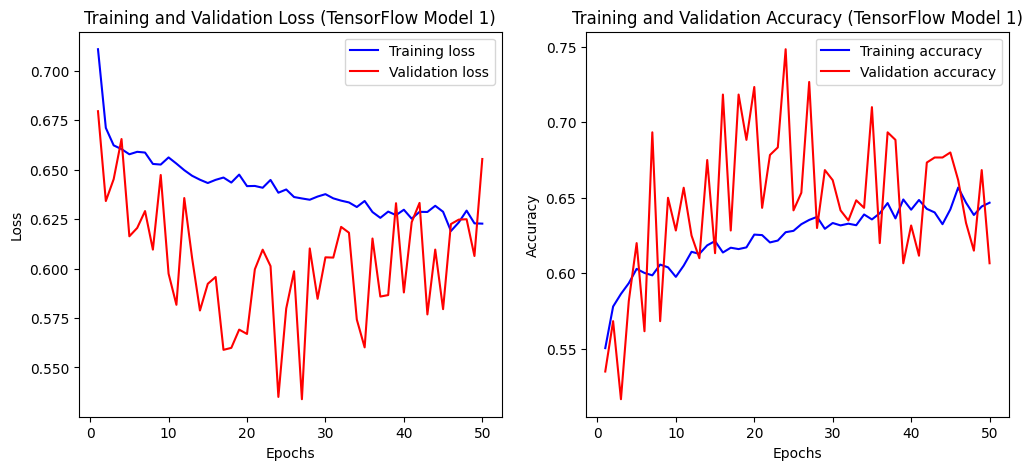

In [108]:
# Get training history
train_loss = history_tf1.history['loss']
val_loss = history_tf1.history['val_loss']
train_acc = history_tf1.history['accuracy']
val_acc = history_tf1.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot loss curves
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss (TensorFlow Model 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy (TensorFlow Model 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [17]:
# Evaluate the model
evaluation = model_tf1.evaluate(test_generator)
test_loss_tf1 = evaluation[0]
test_accuracy_tf1 = evaluation[1]

print(f"Test Loss: {test_loss_tf1:.4f}, Accuracy: {test_accuracy_tf1 * 100:.2f}%")

10/10 [==============================] - 1s 75ms/step - loss: 0.6554 - accuracy: 0.6067
Test Loss: 0.6554, Accuracy: 60.67%


In [18]:
# Predict on test data
predicted_tf1 = model_tf1.predict(test_generator)

# Convert probabilities to binary labels
predicted_labels_tf1 = (predicted_tf1 > 0.5).astype(int)



10/10 [==============================] - 1s 74ms/step


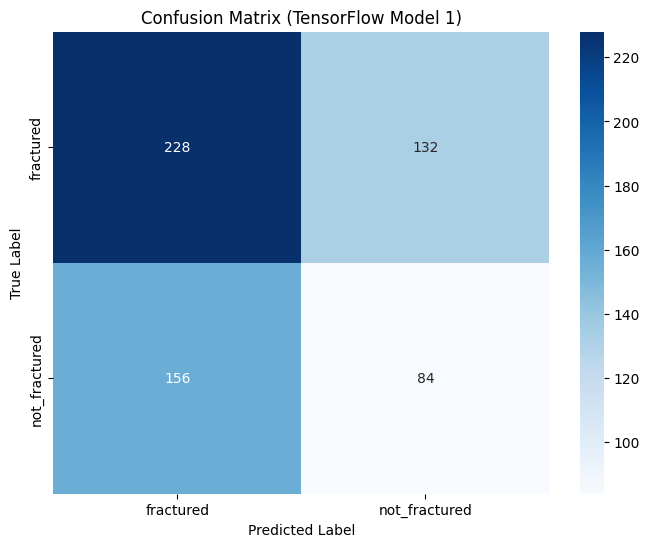

In [109]:
# Extract true labels from test_generator
true_labels = test_generator.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_tf1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (TensorFlow Model 1)')
plt.show()

In [20]:
print(classification_report(true_labels, predicted_labels_tf1, target_names=test_generator.class_indices.keys()))

               precision    recall  f1-score   support

    fractured       0.59      0.63      0.61       360
not_fractured       0.39      0.35      0.37       240

     accuracy                           0.52       600
    macro avg       0.49      0.49      0.49       600
 weighted avg       0.51      0.52      0.52       600



## Pytorch Model 1

In [21]:
class PyTorchModel_1(nn.Module):
    def __init__(self):
        super(PyTorchModel_1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 3 input channels (RGB), 16 output channels, 3x3 kernel
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with kernel size 2x2 and stride 2
        self.fc1 = nn.Linear(16 * 64 * 64, 1)  # Fully connected layer with input size 16*64*64 and output size 1
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function

    def forward(self, x):
        x = torch.relu(self.conv1(x))  # Apply ReLU activation after convolution
        x = self.pool(x)  # Max pooling
        x = torch.flatten(x, 1)  # Flatten the output from the convolutional layers
        x = self.fc1(x)  # Fully connected layer
        x = self.sigmoid(x)  # Apply sigmoid activation
        return x


pytorch_model_1 = PyTorchModel_1()

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.Adam(pytorch_model_1.parameters(), lr=learning_rate)

In [22]:
summary(pytorch_model_1, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
         MaxPool2d-2           [-1, 16, 64, 64]               0
            Linear-3                    [-1, 1]          65,537
           Sigmoid-4                    [-1, 1]               0
Total params: 65,985
Trainable params: 65,985
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 2.50
Params size (MB): 0.25
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [23]:
# Get training history
train_loss_list_pt1 = []  
val_loss_list_pt1 = []    
train_acc_list_pt1 = []  
val_acc_list_pt1 = []
     
# Start time tracking
start_time_pt1 = time.time()

for epoch in range(num_epochs):
    print("Training for epoch {}/{} ...".format(epoch+1, num_epochs))
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    total_batches = len(train_generator)

    for i, (inputs, labels) in enumerate(train_generator, 1):
        # Convert inputs and labels to PyTorch tensors
        inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 3, 1, 2)
        labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
        
        # Forward pass
        outputs = pytorch_model_1(inputs)
        loss = criterion(outputs, labels)

        # Zero the gradients, backward pass, and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.view(-1)).item()
        total_samples += labels.size(0)


        # Check if all samples have been processed
        if total_samples >= len(train_generator.filenames):
            break

    # Calculate epoch statistics
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    # Print epoch statistics
    print(f'Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Append training loss and accuracy to lists
    train_loss_list_pt1.append(epoch_loss)
    train_acc_list_pt1.append(epoch_acc)

    # Validation phase
    val_running_loss = 0.0
    val_running_corrects = 0
    val_total_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in test_generator:
            # Convert inputs and labels to PyTorch tensors
            val_inputs = torch.tensor(val_inputs, dtype=torch.float32).permute(0, 3, 1, 2)
            val_labels = torch.tensor(val_labels, dtype=torch.float32).unsqueeze(1)

            # Forward pass
            val_outputs = pytorch_model_1(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            # Update validation loss and accuracy
            val_running_loss += val_loss.item() * val_inputs.size(0)
            _, val_preds = torch.max(val_outputs, 1)
            val_running_corrects += torch.sum(val_preds == val_labels.view(-1)).item()
            val_total_samples += val_inputs.size(0)

            # Check if all validation samples have been processed
            if val_total_samples >= len(test_generator.filenames):
                break

    # Calculate epoch statistics
    val_epoch_loss = val_running_loss / val_total_samples
    val_epoch_acc = val_running_corrects / val_total_samples

    # Print validation statistics
    print(f'Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}')

    val_loss_list_pt1.append(val_epoch_loss)  
    val_acc_list_pt1.append(val_epoch_acc)    

# Stop time tracking
duration_pt1 = time.time() - start_time_pt1
cpu_usage_pt1, ram_usage_pt1 = monitor_resources()




Training for epoch 1/50 ...
Training Loss: 0.7557, Accuracy: 0.5032
Validation Loss: 0.7748, Accuracy: 0.5917
Training for epoch 2/50 ...
Training Loss: 0.6677, Accuracy: 0.5073
Validation Loss: 0.6576, Accuracy: 0.5900
Training for epoch 3/50 ...
Training Loss: 0.6560, Accuracy: 0.5052
Validation Loss: 0.7309, Accuracy: 0.6083
Training for epoch 4/50 ...
Training Loss: 0.6498, Accuracy: 0.5063
Validation Loss: 0.6584, Accuracy: 0.5883
Training for epoch 5/50 ...
Training Loss: 0.6431, Accuracy: 0.5054
Validation Loss: 0.6613, Accuracy: 0.6150
Training for epoch 6/50 ...
Training Loss: 0.6473, Accuracy: 0.5051
Validation Loss: 0.6497, Accuracy: 0.6083
Training for epoch 7/50 ...
Training Loss: 0.6394, Accuracy: 0.5055
Validation Loss: 0.6248, Accuracy: 0.5833
Training for epoch 8/50 ...
Training Loss: 0.6406, Accuracy: 0.5056
Validation Loss: 0.6172, Accuracy: 0.5967
Training for epoch 9/50 ...
Training Loss: 0.6345, Accuracy: 0.5055
Validation Loss: 0.6476, Accuracy: 0.6100
Training f

In [24]:
# Print training duration and resource usage
print("Training Duration:", duration_pt1, "seconds")
print("CPU Usage:",cpu_usage_pt1, "%")
print("RAM Usage:",ram_usage_pt1,"%")

Training Duration: 2276.5813376903534 seconds
CPU Usage: 45.2 %
RAM Usage: 50.3 %


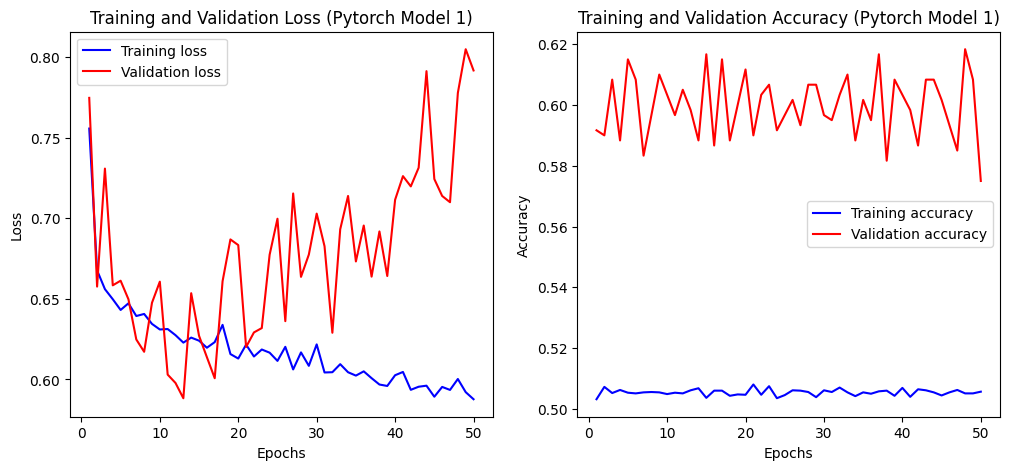

In [99]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_list_pt1, 'b', label='Training loss')
plt.plot(range(1, num_epochs + 1), val_loss_list_pt1, 'r', label='Validation loss')
plt.title('Training and Validation Loss (Pytorch Model 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc_list_pt1, 'b', label='Training accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_list_pt1, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy (Pytorch Model 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [26]:
# Evaluate the PyTorch model
pytorch_model_1.eval()  # Set the model to evaluation mode
test_running_loss_pt1 = 0.0
test_running_corrects_pt1 = 0
test_total_samples_pt1 = 0
predicted_labels_pt1 = []

with torch.no_grad():  # Disable gradient calculation during evaluation
    for inputs, labels in test_generator:
        # Convert inputs and labels to PyTorch tensors
        inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 3, 1, 2)
        labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

        # Forward pass
        outputs = pytorch_model_1(inputs)
        loss = criterion(outputs, labels)
        test_running_loss_pt1 += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        
        # Convert predicted probabilities to binary predictions
        binary_predicted_labels_batch = []
        for output in outputs:
            if output >= 0.5:
                binary_predicted_labels_batch.append(1)
            else:
                binary_predicted_labels_batch.append(0)
        
        predicted_labels_pt1.extend(binary_predicted_labels_batch)
        test_running_corrects_pt1 += torch.sum(preds == labels.view(-1)).item()
        test_total_samples_pt1 += inputs.size(0)
        if test_total_samples_pt1 >= len(test_generator.filenames):
            break

# Calculate evaluation metrics
test_loss_pt1 = test_running_loss_pt1 / test_total_samples_pt1
test_accuracy_pt1 = test_running_corrects_pt1 / test_total_samples_pt1

print(f"Test Loss: {test_loss_pt1:.4f}, Accuracy: {test_accuracy_pt1 * 100:.2f}%")




Test Loss: 0.7623, Accuracy: 62.17%


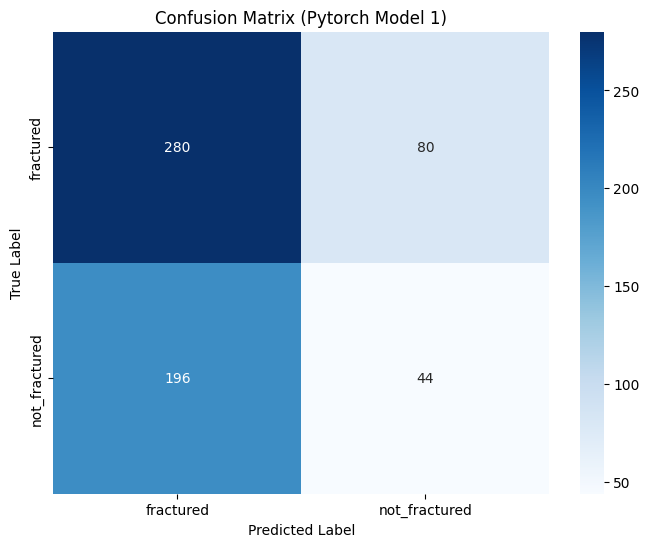

In [110]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_pt1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Pytorch Model 1)')
plt.show()


In [28]:
print(classification_report(true_labels, predicted_labels_pt1, target_names=test_generator.class_indices.keys()))

               precision    recall  f1-score   support

    fractured       0.59      0.78      0.67       360
not_fractured       0.35      0.18      0.24       240

     accuracy                           0.54       600
    macro avg       0.47      0.48      0.46       600
 weighted avg       0.49      0.54      0.50       600



## TensorFlow Model 2

In [29]:
model_tf2 = k.models.Sequential([
    k.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),  
    k.layers.MaxPooling2D((2, 2)),
    k.layers.Flatten(),
    k.layers.Dense(16, activation='relu'),
    k.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

optimizer = k.optimizers.Adam(learning_rate=learning_rate)
loss = k.losses.BinaryCrossentropy()

model_tf2.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)


In [30]:
model_tf2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 63504)             0         
                                                                 
 dense_1 (Dense)             (None, 16)                1016080   
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1016545 (3.88 MB)
Trainable params: 1016545 (3.88 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [31]:
# Start time tracking
start_time_tf2 = start_timer()

# Train the model
history_tf2 = model_tf2.fit(train_generator, epochs=num_epochs, validation_data=test_generator)

# Stop time tracking
duration_tf2 = stop_timer(start_time_tf2)

# Calculate CPU and RAM usage
cpu_usage_tf2, ram_usage_tf2 = monitor_resources()

Epoch 1/50
139/139 [==============================] - 32s 228ms/step - loss: 0.6730 - accuracy: 0.5710 - val_loss: 0.6654 - val_accuracy: 0.5233
Epoch 2/50
139/139 [==============================] - 31s 226ms/step - loss: 0.6595 - accuracy: 0.5909 - val_loss: 0.6132 - val_accuracy: 0.5983
Epoch 3/50
139/139 [==============================] - 31s 226ms/step - loss: 0.6530 - accuracy: 0.6051 - val_loss: 0.6022 - val_accuracy: 0.5667
Epoch 4/50
139/139 [==============================] - 31s 225ms/step - loss: 0.6468 - accuracy: 0.6098 - val_loss: 0.6773 - val_accuracy: 0.5733
Epoch 5/50
139/139 [==============================] - 31s 226ms/step - loss: 0.6424 - accuracy: 0.6175 - val_loss: 0.6227 - val_accuracy: 0.5850
Epoch 6/50
139/139 [==============================] - 31s 225ms/step - loss: 0.6384 - accuracy: 0.6208 - val_loss: 0.5725 - val_accuracy: 0.7083
Epoch 7/50
139/139 [==============================] - 31s 225ms/step - loss: 0.6306 - accuracy: 0.6326 - val_loss: 0.6351 - val_ac

In [32]:
# Print training duration and resource usage
print("Training Duration:", duration_tf2, "seconds")
print("CPU Usage:", cpu_usage_tf2, "%")
print("RAM Usage:",ram_usage_tf2,"%")

Training Duration: 1566.555329322815 seconds
CPU Usage: 7.0 %
RAM Usage: 49.9 %


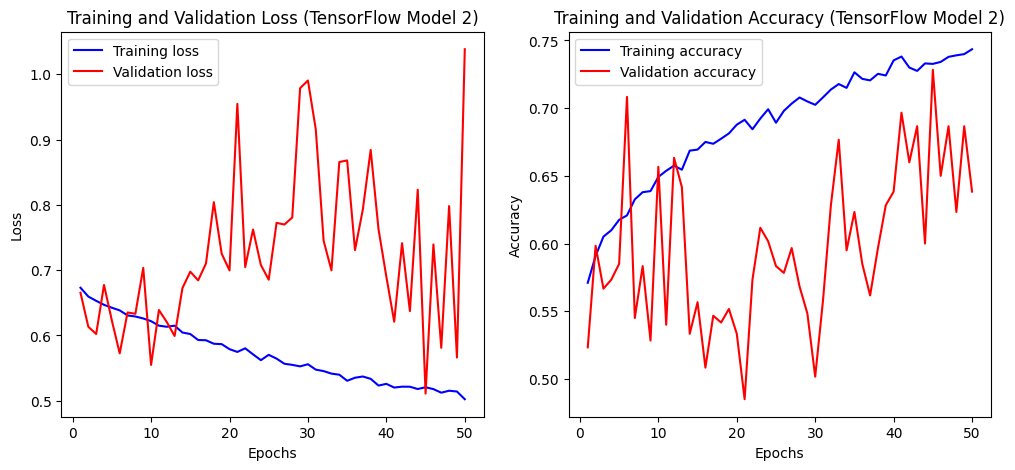

In [111]:
# Get training history
train_loss_tf2 = history_tf2.history['loss']
val_loss_tf2 = history_tf2.history['val_loss']
train_acc_tf2 = history_tf2.history['accuracy']
val_acc_tf2 = history_tf2.history['val_accuracy']
epochs_tf2 = range(1, len(train_loss_tf2) + 1)

# Plot loss curves
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_tf2, train_loss_tf2, 'b', label='Training loss')
plt.plot(epochs_tf2, val_loss_tf2, 'r', label='Validation loss')
plt.title('Training and Validation Loss (TensorFlow Model 2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs_tf2, train_acc_tf2, 'b', label='Training accuracy')
plt.plot(epochs_tf2, val_acc_tf2, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy (TensorFlow Model 2)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [34]:
# Evaluate the model
evaluation_tf2 = model_tf2.evaluate(test_generator)
test_loss_tf2 = evaluation_tf2[0]
test_accuracy_tf2 = evaluation_tf2[1]

print(f"Test Loss: {test_loss_tf2:.4f}, Accuracy: {test_accuracy_tf2 * 100:.2f}%")

10/10 [==============================] - 1s 72ms/step - loss: 1.0384 - accuracy: 0.6383
Test Loss: 1.0384, Accuracy: 63.83%


In [35]:
# Predict on test data
predicted_tf2 = model_tf2.predict(test_generator)

# Convert probabilities to binary labels
predicted_labels_tf2 = (predicted_tf2 > 0.5).astype(int)

10/10 [==============================] - 1s 71ms/step


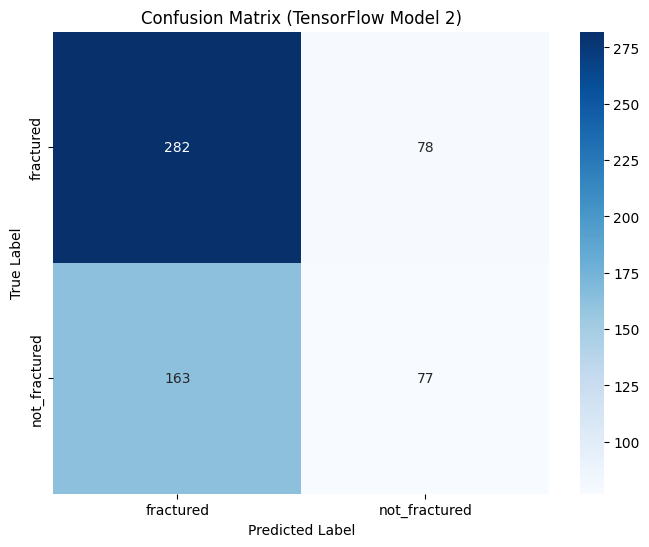

In [112]:
# Calculate confusion matrix
conf_matrix_tf2 = confusion_matrix(true_labels, predicted_labels_tf2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tf2, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (TensorFlow Model 2)')
plt.show()

In [37]:
# Print classification report
print(classification_report(true_labels, predicted_labels_tf2, target_names=test_generator.class_indices.keys()))

               precision    recall  f1-score   support

    fractured       0.63      0.78      0.70       360
not_fractured       0.50      0.32      0.39       240

     accuracy                           0.60       600
    macro avg       0.57      0.55      0.55       600
 weighted avg       0.58      0.60      0.58       600



## Pytorch Model 2

In [126]:
class PyTorchModel_2(nn.Module):
    def __init__(self):
        super(PyTorchModel_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 64 * 64, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # Flattening before fully connected layer
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid activation for binary classification
        return x

# Create an instance of the model
pytorch_model_2 = PyTorchModel_2()

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.Adam(pytorch_model_2.parameters(), lr=learning_rate)

In [127]:
summary(pytorch_model_2, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Linear-3                   [-1, 16]       2,097,168
            Linear-4                    [-1, 1]              17
Total params: 2,098,081
Trainable params: 2,098,081
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 5.00
Params size (MB): 8.00
Estimated Total Size (MB): 13.19
----------------------------------------------------------------


In [129]:
# Get training history
train_loss_list_pt2 = []  
val_loss_list_pt2 = []    
train_acc_list_pt2 = []  
val_acc_list_pt2 = []
     
# Start time tracking
start_time_pt2 = time.time()

for epoch in range(num_epochs):
    print("Training for epoch {}/{} ...".format(epoch+1, num_epochs))
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    total_batches = len(train_generator)

    for i, (inputs, labels) in enumerate(train_generator, 1):
        # Convert inputs and labels to PyTorch tensors
        inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 3, 1, 2)
        labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
        
        # Forward pass
        outputs = pytorch_model_2(inputs)
        loss = criterion(outputs, labels)

        # Zero the gradients, backward pass, and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.view(-1)).item()
        total_samples += labels.size(0)


        # Check if all samples have been processed
        if total_samples >= len(train_generator.filenames):
            break

    # Calculate epoch statistics
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    # Print epoch statistics
    print(f'Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Append training loss and accuracy to lists
    train_loss_list_pt2.append(epoch_loss)
    train_acc_list_pt2.append(epoch_acc)

    # Validation phase
    val_running_loss = 0.0
    val_running_corrects = 0
    val_total_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in test_generator:
            # Convert inputs and labels to PyTorch tensors
            val_inputs = torch.tensor(val_inputs, dtype=torch.float32).permute(0, 3, 1, 2)
            val_labels = torch.tensor(val_labels, dtype=torch.float32).unsqueeze(1)

            # Forward pass
            val_outputs = pytorch_model_2(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            # Update validation loss and accuracy
            val_running_loss += val_loss.item() * val_inputs.size(0)
            _, val_preds = torch.max(val_outputs, 1)
            val_running_corrects += torch.sum(val_preds == val_labels.view(-1)).item()
            val_total_samples += val_inputs.size(0)

            # Check if all validation samples have been processed
            if val_total_samples >= len(test_generator.filenames):
                break

    # Calculate epoch statistics
    val_epoch_loss = val_running_loss / val_total_samples
    val_epoch_acc = val_running_corrects / val_total_samples

    # Print validation statistics
    print(f'Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}')

    val_loss_list_pt2.append(val_epoch_loss)  
    val_acc_list_pt2.append(val_epoch_acc)    

# Stop time tracking
duration_pt2 = time.time() - start_time_pt2
cpu_usage_pt2, ram_usage_pt2 = monitor_resources()

Training for epoch 1/50 ...
Training Loss: 0.6555, Accuracy: 0.5121
Validation Loss: 0.6844, Accuracy: 0.5983
Training for epoch 2/50 ...
Training Loss: 0.6470, Accuracy: 0.5015
Validation Loss: 0.7567, Accuracy: 0.6000
Training for epoch 3/50 ...
Training Loss: 0.6279, Accuracy: 0.5086
Validation Loss: 0.6740, Accuracy: 0.6117
Training for epoch 4/50 ...
Training Loss: 0.6258, Accuracy: 0.5047
Validation Loss: 0.6908, Accuracy: 0.5800
Training for epoch 5/50 ...
Training Loss: 0.6106, Accuracy: 0.5055
Validation Loss: 0.6102, Accuracy: 0.6117
Training for epoch 6/50 ...
Training Loss: 0.6073, Accuracy: 0.5033
Validation Loss: 0.6049, Accuracy: 0.6067
Training for epoch 7/50 ...
Training Loss: 0.6100, Accuracy: 0.5073
Validation Loss: 0.6089, Accuracy: 0.5900
Training for epoch 8/50 ...
Training Loss: 0.5994, Accuracy: 0.5017
Validation Loss: 0.5745, Accuracy: 0.5933
Training for epoch 9/50 ...
Training Loss: 0.5945, Accuracy: 0.5084
Validation Loss: 0.5671, Accuracy: 0.6050
Training f

In [130]:
# Print training duration and resource usage
print("Training Duration:", duration_pt2, "seconds")
print("CPU Usage:",cpu_usage_pt2, "%")
print("RAM Usage:",ram_usage_pt2,"%")

Training Duration: 3990.905091047287 seconds
CPU Usage: 25.0 %
RAM Usage: 61.7 %


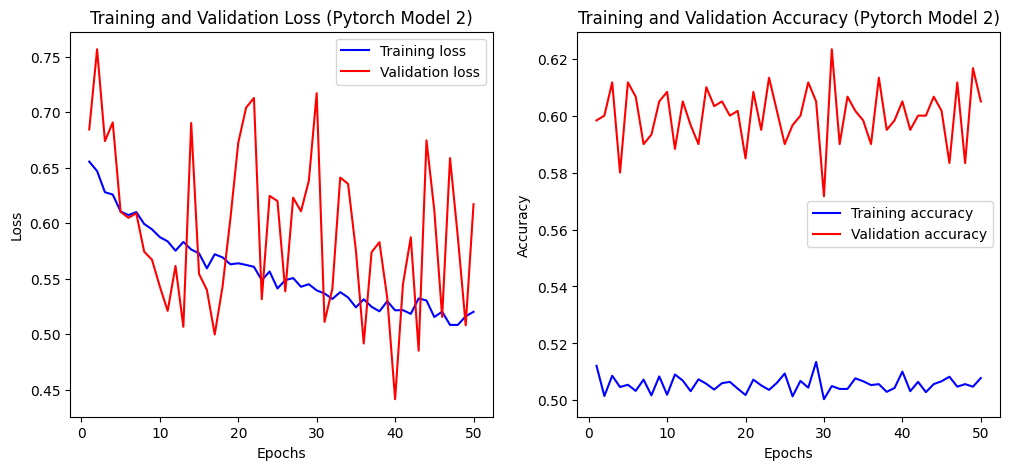

In [131]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))


# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_list_pt2, 'b', label='Training loss')
plt.plot(range(1, num_epochs + 1), val_loss_list_pt2, 'r', label='Validation loss')
plt.title('Training and Validation Loss (Pytorch Model 2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc_list_pt2, 'b', label='Training accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_list_pt2, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy (Pytorch Model 2)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

In [132]:
# Evaluate the PyTorch model
pytorch_model_2.eval()  
test_running_loss_pt2 = 0.0
test_running_corrects_pt2 = 0
test_total_samples_pt2 = 0
predicted_labels_pt2 = []

with torch.no_grad():  # Disable gradient calculation during evaluation
    for inputs, labels in test_generator:
        # Convert inputs and labels to PyTorch tensors
        inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 3, 1, 2)
        labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

        # Forward pass
        outputs = pytorch_model_1(inputs)
        loss = criterion(outputs, labels)

        test_running_loss_pt2 += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
       
        # Convert predicted probabilities to binary predictions
        binary_predicted_labels_batch = []
        for output in outputs:
            if output >= 0.5:
                binary_predicted_labels_batch.append(1)
            else:
                binary_predicted_labels_batch.append(0)
       
        predicted_labels_pt2.extend(binary_predicted_labels_batch)
        test_running_corrects_pt2 += torch.sum(preds == labels.view(-1)).item()
        test_total_samples_pt2 += inputs.size(0)
        if test_total_samples_pt2 >= len(test_generator.filenames):
            break

# Calculate evaluation metrics
test_loss_pt2 = test_running_loss_pt2 / test_total_samples_pt2
test_accuracy_pt2 = test_running_corrects_pt2 / test_total_samples_pt2

print(f"Test Loss: {test_loss_pt2:.4f}, Accuracy: {test_accuracy_pt2 * 100:.2f}%")

Test Loss: 0.7680, Accuracy: 59.50%


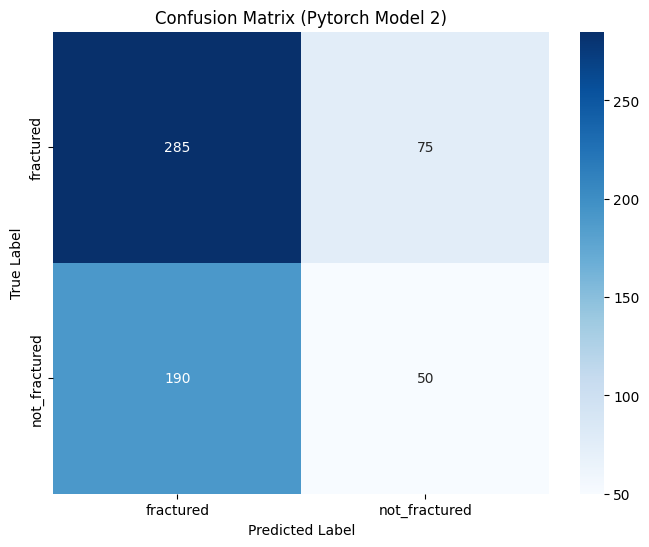

In [133]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_pt2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Pytorch Model 2)')
plt.show()

In [134]:
print(classification_report(true_labels, predicted_labels_pt2, target_names=test_generator.class_indices.keys()))

               precision    recall  f1-score   support

    fractured       0.60      0.79      0.68       360
not_fractured       0.40      0.21      0.27       240

     accuracy                           0.56       600
    macro avg       0.50      0.50      0.48       600
 weighted avg       0.52      0.56      0.52       600



## TensorFlow Model 3

In [46]:
model_tf3 = k.models.Sequential([
    k.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),  
    k.layers.MaxPooling2D((2, 2)),
    k.layers.Conv2D(32, (3, 3), activation='relu'),
    k.layers.MaxPooling2D((2, 2)),
    k.layers.Flatten(),
    k.layers.Dense(16, activation='relu'),
    k.layers.Dense(1, activation='sigmoid')  
])


optimizer = k.optimizers.Adam(learning_rate=learning_rate)
loss = k.losses.BinaryCrossentropy()


model_tf3.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)


In [47]:
model_tf3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 28800)             0         
                                                                 
 dense_3 (Dense)             (None, 16)               

In [48]:
start_time_tf3 = start_timer()


# Train the model
history_tf3 = model_tf3.fit(train_generator, epochs=num_epochs, validation_data=test_generator)


# Stop time tracking
duration_tf3 = stop_timer(start_time_tf3)


# Calculate CPU and RAM usage
cpu_usage_tf3, ram_usage_tf3 = monitor_resources()

Epoch 1/50
139/139 [==============================] - 35s 244ms/step - loss: 0.6910 - accuracy: 0.5512 - val_loss: 0.6964 - val_accuracy: 0.5083
Epoch 2/50
139/139 [==============================] - 34s 243ms/step - loss: 0.6868 - accuracy: 0.5722 - val_loss: 0.6779 - val_accuracy: 0.6000
Epoch 3/50
139/139 [==============================] - 34s 242ms/step - loss: 0.6799 - accuracy: 0.5854 - val_loss: 0.6603 - val_accuracy: 0.7383
Epoch 4/50
139/139 [==============================] - 34s 241ms/step - loss: 0.6686 - accuracy: 0.6180 - val_loss: 0.6484 - val_accuracy: 0.7167
Epoch 5/50
139/139 [==============================] - 34s 241ms/step - loss: 0.6658 - accuracy: 0.6132 - val_loss: 0.6495 - val_accuracy: 0.6917
Epoch 6/50
139/139 [==============================] - 33s 241ms/step - loss: 0.6555 - accuracy: 0.6326 - val_loss: 0.6519 - val_accuracy: 0.6367
Epoch 7/50
139/139 [==============================] - 34s 241ms/step - loss: 0.6523 - accuracy: 0.6387 - val_loss: 0.6301 - val_ac

In [49]:
# Print training duration and resource usage
print("Training Duration:", duration_tf3, "seconds")
print("CPU Usage:", cpu_usage_tf3, "%")
print("RAM Usage:", ram_usage_tf3, "%")

Training Duration: 1681.771321773529 seconds
CPU Usage: 9.0 %
RAM Usage: 50.8 %


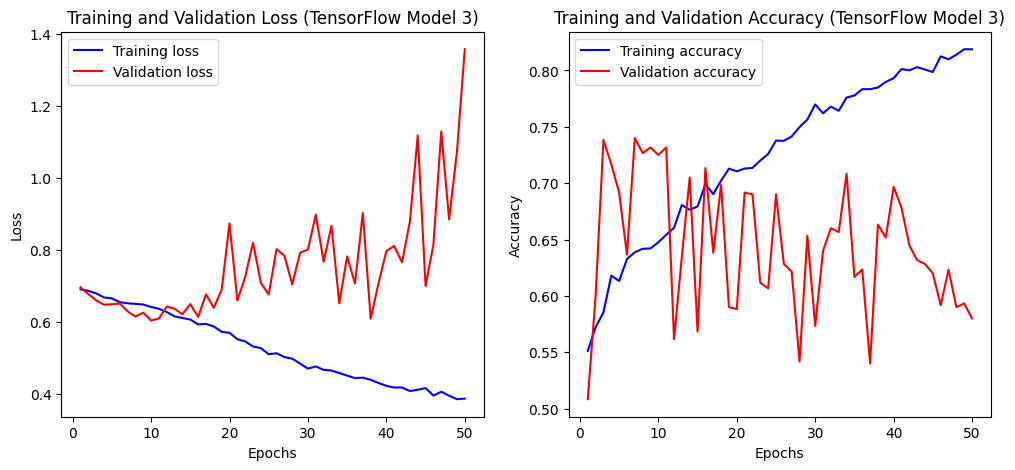

In [115]:
# Get training history
train_loss = history_tf3.history['loss']
val_loss = history_tf3.history['val_loss']
train_acc = history_tf3.history['accuracy']
val_acc = history_tf3.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)


# Plot loss curves
plt.figure(figsize=(12, 5))


# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss (TensorFlow Model 3)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy (TensorFlow Model 3)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

In [51]:
# Evaluate the model
evaluation = model_tf3.evaluate(test_generator)
test_loss_tf3 = evaluation[0]
test_accuracy_tf3 = evaluation[1]


print(f"Test Loss: {test_loss_tf3:.4f}, Accuracy: {test_accuracy_tf3 * 100:.2f}%")

10/10 [==============================] - 1s 78ms/step - loss: 1.3571 - accuracy: 0.5800
Test Loss: 1.3571, Accuracy: 58.00%


In [52]:
# Predict on test data
predicted_tf3 = model_tf3.predict(test_generator)

# Convert probabilities to binary labels
predicted_labels_tf3 = (predicted_tf3 > 0.5).astype(int)


10/10 [==============================] - 1s 78ms/step


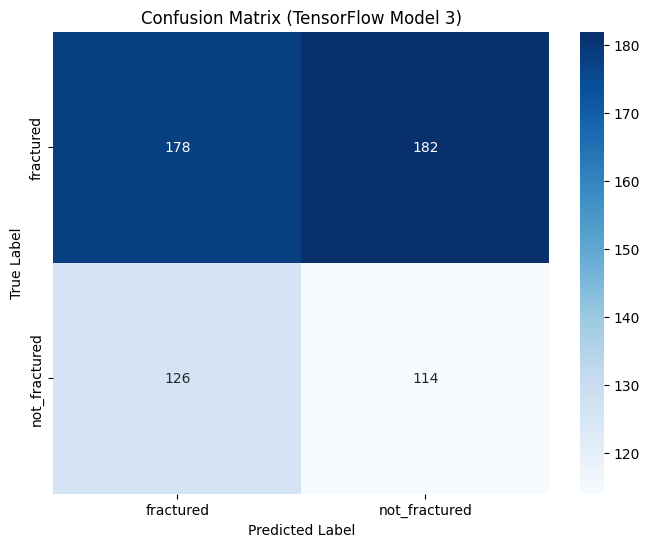

In [116]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_tf3)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (TensorFlow Model 3)')
plt.show()

In [54]:
print(classification_report(true_labels, predicted_labels_tf3, target_names=test_generator.class_indices.keys()))

               precision    recall  f1-score   support

    fractured       0.59      0.49      0.54       360
not_fractured       0.39      0.47      0.43       240

     accuracy                           0.49       600
    macro avg       0.49      0.48      0.48       600
 weighted avg       0.51      0.49      0.49       600



## Pytorch Model 3

In [55]:
class PyTorchModel_3(nn.Module):
    def __init__(self):
        super(PyTorchModel_3, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)  # 3 input channels, 16 output channels, kernel size 3x3
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling over a 2x2 window
        self.conv2 = nn.Conv2d(16, 32, 3)  # 16 input channels (from previous layer), 32 output channels, kernel size 3x3
        self.fc1 = nn.Linear(32 * 30 * 30, 16)  # Fully connected layer, input size 32*30*30 (output of previous layer), output size 16
        self.fc2 = nn.Linear(16, 1)  # Output layer, input size 16, output size 1
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply ReLU activation after first convolutional layer
        x = self.pool(x)  # Apply max pooling
        x = F.relu(self.conv2(x))  # Apply ReLU activation after second convolutional layer
        x = self.pool(x)  # Apply max pooling
        x = torch.flatten(x, 1)  # Flatten the tensor for input to fully connected layer
        x = F.relu(self.fc1(x))  # Apply ReLU activation to first fully connected layer
        x = self.fc2(x)  # Apply second fully connected layer
        x = self.sigmoid(x)  # Apply sigmoid activation function to get probabilities
        return x

# Create an instance of the model
pytorch_model_3 = PyTorchModel_3()

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.Adam(pytorch_model_3.parameters(), lr=learning_rate)

In [56]:
summary(pytorch_model_3, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             448
         MaxPool2d-2           [-1, 16, 63, 63]               0
            Conv2d-3           [-1, 32, 61, 61]           4,640
         MaxPool2d-4           [-1, 32, 30, 30]               0
            Linear-5                   [-1, 16]         460,816
            Linear-6                    [-1, 1]              17
           Sigmoid-7                    [-1, 1]               0
Total params: 465,921
Trainable params: 465,921
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 3.55
Params size (MB): 1.78
Estimated Total Size (MB): 5.52
----------------------------------------------------------------


In [57]:
# Get training history
train_loss_list_pt3 = []  
val_loss_list_pt3 = []    
train_acc_list_pt3 = []  
val_acc_list_pt3 = []
     
# Start time tracking
start_time_pt3 = time.time()

for epoch in range(num_epochs):
    print("Training for epoch {}/{} ...".format(epoch+1, num_epochs))
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    total_batches = len(train_generator)

    for i, (inputs, labels) in enumerate(train_generator, 1):
        # Convert inputs and labels to PyTorch tensors
        inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 3, 1, 2)
        labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
        
        # Forward pass
        outputs = pytorch_model_3(inputs)
        loss = criterion(outputs, labels)

        # Zero the gradients, backward pass, and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.view(-1)).item()
        total_samples += labels.size(0)


        # Check if all samples have been processed
        if total_samples >= len(train_generator.filenames):
            break

    # Calculate epoch statistics
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    # Print epoch statistics
    print(f'Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Append training loss and accuracy to lists
    train_loss_list_pt3.append(epoch_loss)
    train_acc_list_pt3.append(epoch_acc)

    # Validation phase
    val_running_loss = 0.0
    val_running_corrects = 0
    val_total_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in test_generator:
            # Convert inputs and labels to PyTorch tensors
            val_inputs = torch.tensor(val_inputs, dtype=torch.float32).permute(0, 3, 1, 2)
            val_labels = torch.tensor(val_labels, dtype=torch.float32).unsqueeze(1)

            # Forward pass
            val_outputs = pytorch_model_3(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            # Update validation loss and accuracy
            val_running_loss += val_loss.item() * val_inputs.size(0)
            _, val_preds = torch.max(val_outputs, 1)
            val_running_corrects += torch.sum(val_preds == val_labels.view(-1)).item()
            val_total_samples += val_inputs.size(0)

            # Check if all validation samples have been processed
            if val_total_samples >= len(test_generator.filenames):
                break

    # Calculate epoch statistics
    val_epoch_loss = val_running_loss / val_total_samples
    val_epoch_acc = val_running_corrects / val_total_samples

    # Print validation statistics
    print(f'Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}')

    val_loss_list_pt3.append(val_epoch_loss)  
    val_acc_list_pt3.append(val_epoch_acc)    

# Stop time tracking
duration_pt3 = time.time() - start_time_pt3
cpu_usage_pt3, ram_usage_pt3 = monitor_resources()

Training for epoch 1/50 ...
Training Loss: 0.6862, Accuracy: 0.5043
Validation Loss: 0.7194, Accuracy: 0.5933
Training for epoch 2/50 ...
Training Loss: 0.6697, Accuracy: 0.5056
Validation Loss: 0.7750, Accuracy: 0.6100
Training for epoch 3/50 ...
Training Loss: 0.6564, Accuracy: 0.5047
Validation Loss: 0.7073, Accuracy: 0.5900
Training for epoch 4/50 ...
Training Loss: 0.6427, Accuracy: 0.5082
Validation Loss: 0.5958, Accuracy: 0.6000
Training for epoch 5/50 ...
Training Loss: 0.6282, Accuracy: 0.5039
Validation Loss: 0.5879, Accuracy: 0.6167
Training for epoch 6/50 ...
Training Loss: 0.6160, Accuracy: 0.5058
Validation Loss: 0.5649, Accuracy: 0.5900
Training for epoch 7/50 ...
Training Loss: 0.6089, Accuracy: 0.5055
Validation Loss: 0.6135, Accuracy: 0.5983
Training for epoch 8/50 ...
Training Loss: 0.6026, Accuracy: 0.5043
Validation Loss: 0.5840, Accuracy: 0.5983
Training for epoch 9/50 ...
Training Loss: 0.5967, Accuracy: 0.5051
Validation Loss: 0.6141, Accuracy: 0.6050
Training f

In [58]:
# Print training duration and resource usage
print("Training Duration:", duration_pt3, "seconds")
print("CPU Usage:",cpu_usage_pt3, "%")
print("RAM Usage:",ram_usage_pt3,"%")

Training Duration: 2465.914909362793 seconds
CPU Usage: 45.2 %
RAM Usage: 52.1 %


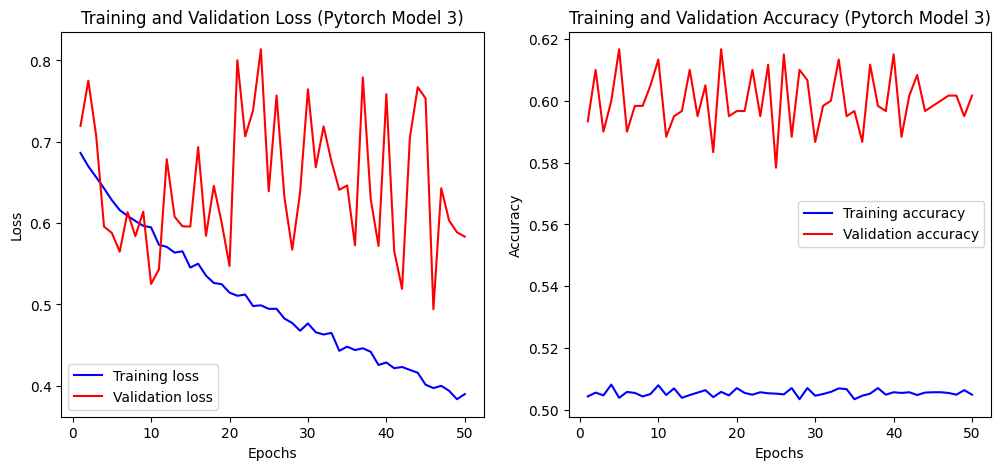

In [103]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))


# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_list_pt3, 'b', label='Training loss')
plt.plot(range(1, num_epochs + 1), val_loss_list_pt3, 'r', label='Validation loss')
plt.title('Training and Validation Loss (Pytorch Model 3)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc_list_pt3, 'b', label='Training accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_list_pt3, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy (Pytorch Model 3)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

In [60]:
# Evaluate the PyTorch model
pytorch_model_3.eval()  # Set the model to evaluation mode
test_running_loss_pt3 = 0.0
test_running_corrects_pt3 = 0
test_total_samples_pt3 = 0
predicted_labels_pt3 = []

with torch.no_grad():  # Disable gradient calculation during evaluation
    for inputs, labels in test_generator:
        # Convert inputs and labels to PyTorch tensors
        inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 3, 1, 2)
        labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

        # Forward pass
        outputs = pytorch_model_1(inputs)
        loss = criterion(outputs, labels)

        test_running_loss_pt3 += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
       
        # Convert predicted probabilities to binary predictions
        binary_predicted_labels_batch = []
        for output in outputs:
            if output >= 0.5:
                binary_predicted_labels_batch.append(1)
            else:
                binary_predicted_labels_batch.append(0)
       
        predicted_labels_pt3.extend(binary_predicted_labels_batch)
        test_running_corrects_pt3 += torch.sum(preds == labels.view(-1)).item()
        test_total_samples_pt3 += inputs.size(0)
        if test_total_samples_pt3 >= len(test_generator.filenames):
            break

# Calculate evaluation metrics
test_loss_pt3 = test_running_loss_pt3 / test_total_samples_pt3
test_accuracy_pt3 = test_running_corrects_pt3 / test_total_samples_pt3

print(f"Test Loss: {test_loss_pt3:.4f}, Accuracy: {test_accuracy_pt3 * 100:.2f}%")


Test Loss: 0.7577, Accuracy: 60.33%


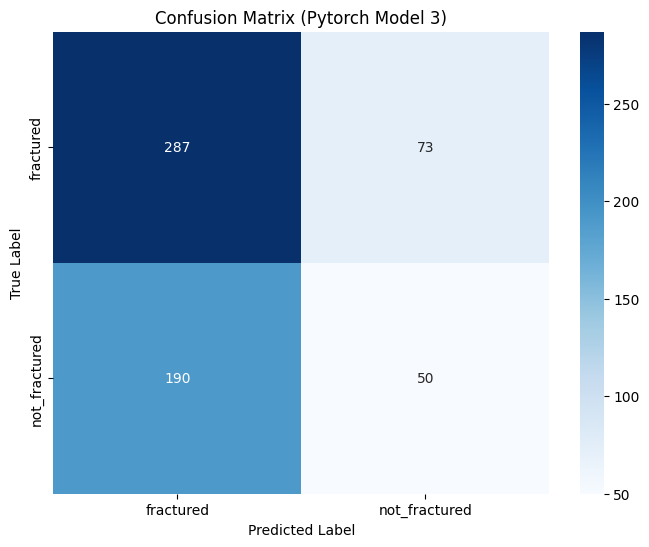

In [117]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_pt3)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Pytorch Model 3)')
plt.show()

In [62]:
print(classification_report(true_labels, predicted_labels_pt3, target_names=test_generator.class_indices.keys()))

               precision    recall  f1-score   support

    fractured       0.60      0.80      0.69       360
not_fractured       0.41      0.21      0.28       240

     accuracy                           0.56       600
    macro avg       0.50      0.50      0.48       600
 weighted avg       0.52      0.56      0.52       600



## TensorFlow Model 4

In [63]:
model_tf4 = k.models.Sequential([
    k.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),  
    k.layers.MaxPooling2D((2, 2)),
    k.layers.Conv2D(32, (3, 3), activation='relu'),
    k.layers.MaxPooling2D((2, 2)),
    k.layers.Conv2D(64, (3, 3), activation='relu'),  
    k.layers.MaxPooling2D((2, 2)), 
    k.layers.Flatten(),
    k.layers.Dense(32, activation='relu'), 
    k.layers.Dense(16, activation='relu'),
    k.layers.Dense(1, activation='sigmoid')  
])

optimizer = k.optimizers.Adam(learning_rate=learning_rate)
loss = k.losses.BinaryCrossentropy()

model_tf4.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)


In [64]:
model_tf4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 64)       

In [65]:
start_time_tf4 = start_timer()

# Train the model
history_tf4 = model_tf4.fit(train_generator, epochs=num_epochs, validation_data=test_generator)

# Stop time tracking
duration_tf4 = stop_timer(start_time_tf4)

# Calculate CPU and RAM usage
cpu_usage_tf4, ram_usage_tf4 = monitor_resources()

Epoch 1/50
139/139 [==============================] - 36s 253ms/step - loss: 0.6763 - accuracy: 0.5641 - val_loss: 0.7106 - val_accuracy: 0.4417
Epoch 2/50
139/139 [==============================] - 35s 251ms/step - loss: 0.6530 - accuracy: 0.5975 - val_loss: 0.5533 - val_accuracy: 0.5817
Epoch 3/50
139/139 [==============================] - 35s 249ms/step - loss: 0.6232 - accuracy: 0.6312 - val_loss: 0.6204 - val_accuracy: 0.5633
Epoch 4/50
139/139 [==============================] - 35s 251ms/step - loss: 0.5888 - accuracy: 0.6692 - val_loss: 0.6919 - val_accuracy: 0.5483
Epoch 5/50
139/139 [==============================] - 35s 249ms/step - loss: 0.5636 - accuracy: 0.6928 - val_loss: 0.5510 - val_accuracy: 0.6733
Epoch 6/50
139/139 [==============================] - 35s 249ms/step - loss: 0.5219 - accuracy: 0.7281 - val_loss: 0.6217 - val_accuracy: 0.5933
Epoch 7/50
139/139 [==============================] - 35s 249ms/step - loss: 0.5158 - accuracy: 0.7297 - val_loss: 0.5947 - val_ac

In [66]:
# Print training duration and resource usage
print("Training Duration:", duration_tf4, "seconds")
print("CPU Usage:", cpu_usage_tf4, "%")
print("RAM Usage:", ram_usage_tf4, "%")

Training Duration: 1749.1815843582153 seconds
CPU Usage: 9.7 %
RAM Usage: 51.9 %


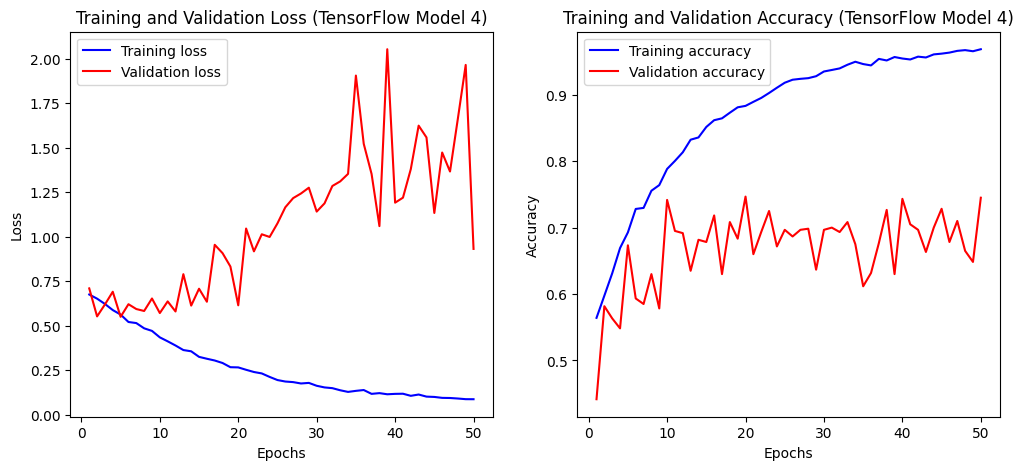

In [118]:
# Get training history
train_loss = history_tf4.history['loss']
val_loss = history_tf4.history['val_loss']
train_acc = history_tf4.history['accuracy']
val_acc = history_tf4.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot loss curves
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss (TensorFlow Model 4)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy (TensorFlow Model 4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [68]:
# Evaluate the model
evaluation = model_tf4.evaluate(test_generator)
test_loss_tf4 = evaluation[0]
test_accuracy_tf4 = evaluation[1]

print(f"Test Loss: {test_loss_tf4:.4f}, Accuracy: {test_accuracy_tf4 * 100:.2f}%")

10/10 [==============================] - 1s 78ms/step - loss: 0.9324 - accuracy: 0.7450
Test Loss: 0.9324, Accuracy: 74.50%


In [69]:
# Predict on test data
predicted_tf4 = model_tf4.predict(test_generator)

# Convert probabilities to binary labels
predicted_labels_tf4 = (predicted_tf4 > 0.5).astype(int)

10/10 [==============================] - 1s 82ms/step


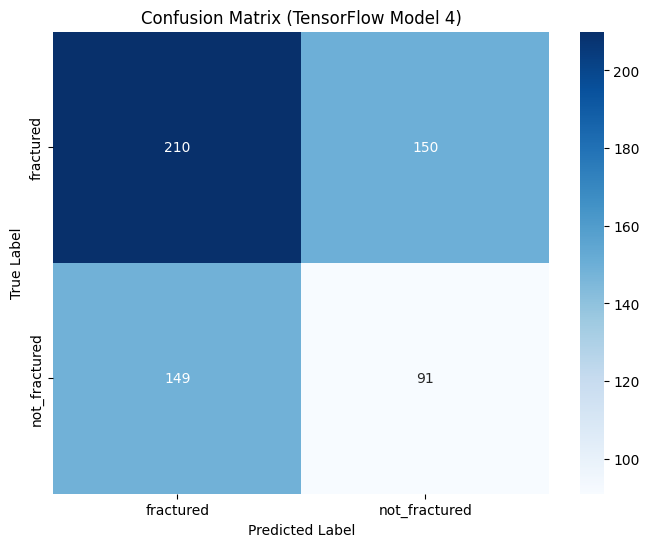

In [119]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_tf4)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (TensorFlow Model 4)')
plt.show()

In [71]:
print(classification_report(true_labels, predicted_labels_tf4, target_names=test_generator.class_indices.keys()))

               precision    recall  f1-score   support

    fractured       0.58      0.58      0.58       360
not_fractured       0.38      0.38      0.38       240

     accuracy                           0.50       600
    macro avg       0.48      0.48      0.48       600
 weighted avg       0.50      0.50      0.50       600



## Pytorch Model 4

In [72]:
class PyTorchModel_4(nn.Module):
    def __init__(self):
        super(PyTorchModel_4, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 3 input channels, 16 output channels, kernel size 3x3
        self.pool1 = nn.MaxPool2d(2, 2)  # Max pooling over a 2x2 window
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 16 input channels (from previous layer), 32 output channels, kernel size 3x3
        self.pool2 = nn.MaxPool2d(2, 2)  # Max pooling over a 2x2 window
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32 input channels (from previous layer), 64 output channels, kernel size 3x3
        self.pool3 = nn.MaxPool2d(2, 2)  # Max pooling over a 2x2 window
        self.fc1 = nn.Linear(64 * 16 * 16, 32)  # Fully connected layer, input size 64*16*16 (output of previous layer), output size 32
        self.fc2 = nn.Linear(32, 16)  # Fully connected layer, input size 32, output size 16
        self.fc3 = nn.Linear(16, 1)  # Output layer, input size 16, output size 1
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply ReLU activation after first convolutional layer
        x = self.pool1(x)  # Apply max pooling
        x = F.relu(self.conv2(x))  # Apply ReLU activation after second convolutional layer
        x = self.pool2(x)  # Apply max pooling
        x = F.relu(self.conv3(x))  # Apply ReLU activation after third convolutional layer
        x = self.pool3(x)  # Apply max pooling
        x = torch.flatten(x, 1)  # Flatten the tensor for input to fully connected layer
        x = F.relu(self.fc1(x))  # Apply ReLU activation to first fully connected layer
        x = F.relu(self.fc2(x))  # Apply ReLU activation to second fully connected layer
        x = self.fc3(x)  # Apply third fully connected layer
        x = self.sigmoid(x)  # Apply sigmoid activation function to get probabilities
        return x

# Create an instance of the model
pytorch_model_4 = PyTorchModel_4()

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.Adam(pytorch_model_4.parameters(), lr=learning_rate)


In [73]:
summary(pytorch_model_4, input_size=(3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
         MaxPool2d-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 32, 64, 64]           4,640
         MaxPool2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Linear-7                   [-1, 32]         524,320
            Linear-8                   [-1, 16]             528
            Linear-9                    [-1, 1]              17
          Sigmoid-10                    [-1, 1]               0
Total params: 548,449
Trainable params: 548,449
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 4.38
Params size (MB): 2.09
Estimated T

In [74]:
# Get training history
train_loss_list_pt4 = []  
val_loss_list_pt4 = []    
train_acc_list_pt4 = []  
val_acc_list_pt4 = []
     
# Start time tracking
start_time_pt4 = time.time()

for epoch in range(num_epochs):
    print("Training for epoch {}/{} ...".format(epoch+1, num_epochs))
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    total_batches = len(train_generator)

    for i, (inputs, labels) in enumerate(train_generator, 1):
        # Convert inputs and labels to PyTorch tensors
        inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 3, 1, 2)
        labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
        
        # Forward pass
        outputs = pytorch_model_4(inputs)
        loss = criterion(outputs, labels)

        # Zero the gradients, backward pass, and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.view(-1)).item()
        total_samples += labels.size(0)


        # Check if all samples have been processed
        if total_samples >= len(train_generator.filenames):
            break

    # Calculate epoch statistics
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    # Print epoch statistics
    print(f'Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Append training loss and accuracy to lists
    train_loss_list_pt4.append(epoch_loss)
    train_acc_list_pt4.append(epoch_acc)

    # Validation phase
    val_running_loss = 0.0
    val_running_corrects = 0
    val_total_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in test_generator:
            # Convert inputs and labels to PyTorch tensors
            val_inputs = torch.tensor(val_inputs, dtype=torch.float32).permute(0, 3, 1, 2)
            val_labels = torch.tensor(val_labels, dtype=torch.float32).unsqueeze(1)

            # Forward pass
            val_outputs = pytorch_model_4(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            # Update validation loss and accuracy
            val_running_loss += val_loss.item() * val_inputs.size(0)
            _, val_preds = torch.max(val_outputs, 1)
            val_running_corrects += torch.sum(val_preds == val_labels.view(-1)).item()
            val_total_samples += val_inputs.size(0)

            # Check if all validation samples have been processed
            if val_total_samples >= len(test_generator.filenames):
                break

    # Calculate epoch statistics
    val_epoch_loss = val_running_loss / val_total_samples
    val_epoch_acc = val_running_corrects / val_total_samples

    # Print validation statistics
    print(f'Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}')

    val_loss_list_pt4.append(val_epoch_loss)  
    val_acc_list_pt4.append(val_epoch_acc)    

# Stop time tracking
duration_pt4 = time.time() - start_time_pt4
cpu_usage_pt4, ram_usage_pt4 = monitor_resources()


Training for epoch 1/50 ...
Training Loss: 0.6802, Accuracy: 0.5061
Validation Loss: 0.7102, Accuracy: 0.6133
Training for epoch 2/50 ...
Training Loss: 0.6631, Accuracy: 0.5048
Validation Loss: 0.6622, Accuracy: 0.5967
Training for epoch 3/50 ...
Training Loss: 0.6436, Accuracy: 0.5056
Validation Loss: 0.6456, Accuracy: 0.6017
Training for epoch 4/50 ...
Training Loss: 0.6268, Accuracy: 0.5069
Validation Loss: 0.5543, Accuracy: 0.6033
Training for epoch 5/50 ...
Training Loss: 0.6118, Accuracy: 0.5036
Validation Loss: 0.6168, Accuracy: 0.5967
Training for epoch 6/50 ...
Training Loss: 0.5894, Accuracy: 0.5058
Validation Loss: 0.5568, Accuracy: 0.5983
Training for epoch 7/50 ...
Training Loss: 0.5601, Accuracy: 0.5051
Validation Loss: 0.5265, Accuracy: 0.6033
Training for epoch 8/50 ...
Training Loss: 0.5414, Accuracy: 0.5052
Validation Loss: 0.5859, Accuracy: 0.6150
Training for epoch 9/50 ...
Training Loss: 0.4998, Accuracy: 0.5077
Validation Loss: 0.4929, Accuracy: 0.5900
Training f

In [75]:
# Print training duration and resource usage
print("Training Duration:", duration_pt4, "seconds")
print("CPU Usage:",cpu_usage_pt4, "%")
print("RAM Usage:",ram_usage_pt4,"%")

Training Duration: 2601.2702984809875 seconds
CPU Usage: 45.9 %
RAM Usage: 53.6 %


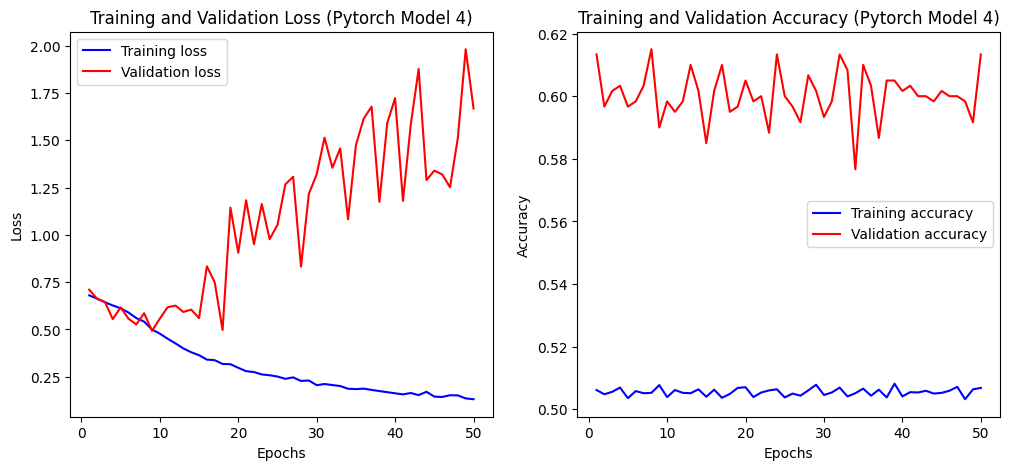

In [105]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))


# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_list_pt4, 'b', label='Training loss')
plt.plot(range(1, num_epochs + 1), val_loss_list_pt4, 'r', label='Validation loss')
plt.title('Training and Validation Loss (Pytorch Model 4)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc_list_pt4, 'b', label='Training accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_list_pt4, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy (Pytorch Model 4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

In [77]:
# Evaluate the PyTorch model
pytorch_model_4.eval()  # Set the model to evaluation mode
test_running_loss_pt4 = 0.0
test_running_corrects_pt4 = 0
test_total_samples_pt4 = 0
predicted_labels_pt4 = []

with torch.no_grad():  # Disable gradient calculation during evaluation
    for inputs, labels in test_generator:
        # Convert inputs and labels to PyTorch tensors
        inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 3, 1, 2)
        labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

        # Forward pass
        outputs = pytorch_model_1(inputs)
        loss = criterion(outputs, labels)

        test_running_loss_pt4 += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
       
        # Convert predicted probabilities to binary predictions
        binary_predicted_labels_batch = []
        for output in outputs:
            if output >= 0.5:
                binary_predicted_labels_batch.append(1)
            else:
                binary_predicted_labels_batch.append(0)
       
        predicted_labels_pt4.extend(binary_predicted_labels_batch)
        test_running_corrects_pt4 += torch.sum(preds == labels.view(-1)).item()
        test_total_samples_pt4 += inputs.size(0)
        if test_total_samples_pt4 >= len(test_generator.filenames):
            break

# Calculate evaluation metrics
test_loss_pt4 = test_running_loss_pt4 / test_total_samples_pt4
test_accuracy_pt4 = test_running_corrects_pt4 / test_total_samples_pt4

print(f"Test Loss: {test_loss_pt4:.4f}, Accuracy: {test_accuracy_pt4 * 100:.2f}%")


Test Loss: 0.7937, Accuracy: 58.83%


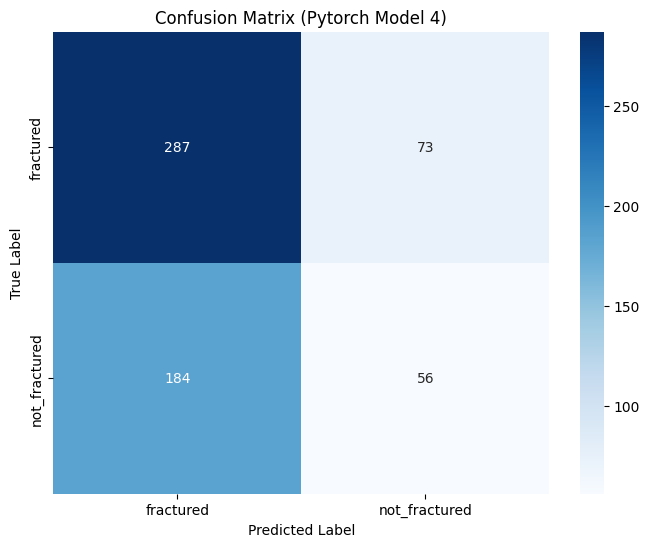

In [120]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_pt4)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Pytorch Model 4)')
plt.show()

In [79]:
print(classification_report(true_labels, predicted_labels_pt4, target_names=test_generator.class_indices.keys()))

               precision    recall  f1-score   support

    fractured       0.61      0.80      0.69       360
not_fractured       0.43      0.23      0.30       240

     accuracy                           0.57       600
    macro avg       0.52      0.52      0.50       600
 weighted avg       0.54      0.57      0.54       600



## TensorFlow Model 5

In [80]:
model_tf5 = k.models.Sequential([
    k.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),  
    k.layers.MaxPooling2D((2, 2)),
    k.layers.Conv2D(32, (3, 3), activation='relu'),
    k.layers.MaxPooling2D((2, 2)),
    k.layers.Conv2D(64, (3, 3), activation='relu'),  
    k.layers.MaxPooling2D((2, 2)), 
    k.layers.Dropout(0.25),  # Dropout layer
    k.layers.BatchNormalization(),  # Batch normalization layer
    
    k.layers.Flatten(),
    k.layers.Dense(32, activation='relu'), 
    k.layers.Dense(16, activation='relu'),
    k.layers.Dense(1, activation='sigmoid')  
])

optimizer = k.optimizers.Adam(learning_rate=learning_rate)
loss = k.losses.BinaryCrossentropy()

model_tf5.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)


In [81]:
model_tf5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 14, 14, 64)       

In [82]:
start_time_tf5 = start_timer()

# Train the model
history_tf5 = model_tf5.fit(train_generator, epochs=num_epochs, validation_data=test_generator)

# Stop time tracking
duration_tf5 = stop_timer(start_time_tf5)

# Calculate CPU and RAM usage
cpu_usage_tf5, ram_usage_tf5 = monitor_resources()

Epoch 1/50
139/139 [==============================] - 37s 256ms/step - loss: 0.6762 - accuracy: 0.5675 - val_loss: 0.6787 - val_accuracy: 0.4450
Epoch 2/50
139/139 [==============================] - 35s 254ms/step - loss: 0.6503 - accuracy: 0.5987 - val_loss: 0.9761 - val_accuracy: 0.6000
Epoch 3/50
139/139 [==============================] - 35s 254ms/step - loss: 0.6377 - accuracy: 0.6211 - val_loss: 0.7647 - val_accuracy: 0.4900
Epoch 4/50
139/139 [==============================] - 35s 253ms/step - loss: 0.6166 - accuracy: 0.6408 - val_loss: 0.5522 - val_accuracy: 0.6850
Epoch 5/50
139/139 [==============================] - 36s 255ms/step - loss: 0.5923 - accuracy: 0.6638 - val_loss: 0.4667 - val_accuracy: 0.7100
Epoch 6/50
139/139 [==============================] - 35s 253ms/step - loss: 0.5649 - accuracy: 0.6942 - val_loss: 0.5733 - val_accuracy: 0.5717
Epoch 7/50
139/139 [==============================] - 35s 254ms/step - loss: 0.5419 - accuracy: 0.7098 - val_loss: 0.5356 - val_ac

In [83]:
# Print training duration and resource usage
print("Training Duration:", duration_tf5, "seconds")
print("CPU Usage:", cpu_usage_tf5, "%")
print("RAM Usage:", ram_usage_tf5, "%")

Training Duration: 1771.6708092689514 seconds
CPU Usage: 8.5 %
RAM Usage: 51.5 %


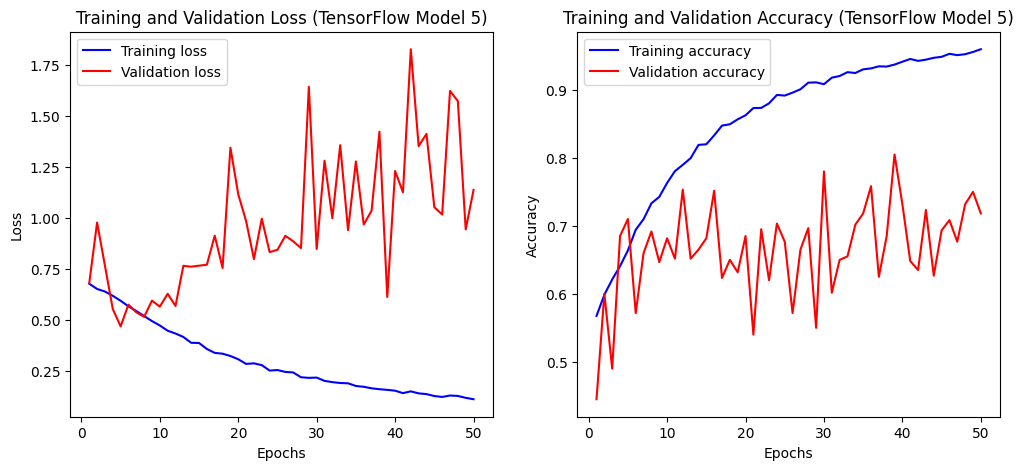

In [121]:
# Get training history
train_loss_tf5 = history_tf5.history['loss']
val_loss_tf5 = history_tf5.history['val_loss']
train_acc_tf5 = history_tf5.history['accuracy']
val_acc_tf5 = history_tf5.history['val_accuracy']
epochs_tf5 = range(1, len(train_loss_tf5) + 1)

# Plot loss curves
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_tf5, train_loss_tf5, 'b', label='Training loss')
plt.plot(epochs_tf5, val_loss_tf5, 'r', label='Validation loss')
plt.title('Training and Validation Loss (TensorFlow Model 5)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs_tf5, train_acc_tf5, 'b', label='Training accuracy')
plt.plot(epochs_tf5, val_acc_tf5, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy (TensorFlow Model 5)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [85]:
# Evaluate the model
evaluation_tf5 = model_tf5.evaluate(test_generator)
test_loss_tf5 = evaluation_tf5[0]
test_accuracy_tf5 = evaluation_tf5[1]

print(f"Test Loss: {test_loss_tf5:.4f}, Accuracy: {test_accuracy_tf5 * 100:.2f}%")

10/10 [==============================] - 1s 82ms/step - loss: 1.1362 - accuracy: 0.7183
Test Loss: 1.1362, Accuracy: 71.83%


In [86]:
# Predict on test data
predicted_tf5 = model_tf5.predict(test_generator)

# Convert probabilities to binary labels
predicted_labels_tf5 = (predicted_tf4 > 0.5).astype(int)

10/10 [==============================] - 1s 79ms/step


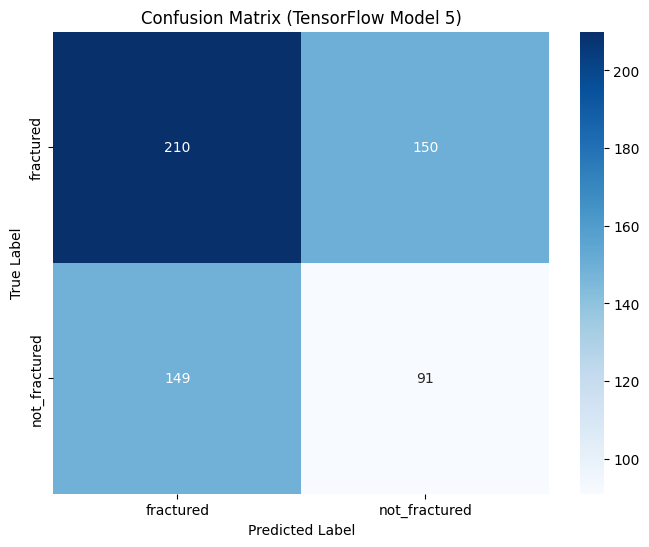

In [122]:
# Calculate confusion matrix
conf_matrix_tf5 = confusion_matrix(true_labels, predicted_labels_tf5)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tf5, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (TensorFlow Model 5)')
plt.show()

In [88]:
print(classification_report(true_labels, predicted_labels_tf5, target_names=test_generator.class_indices.keys()))

               precision    recall  f1-score   support

    fractured       0.58      0.58      0.58       360
not_fractured       0.38      0.38      0.38       240

     accuracy                           0.50       600
    macro avg       0.48      0.48      0.48       600
 weighted avg       0.50      0.50      0.50       600



## Pytorch Model 5

In [89]:
class PyTorchModel_5(nn.Module):
    def __init__(self):
        super(PyTorchModel_5, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.batchnorm = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 14 * 14, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout(x)
        x = self.batchnorm(x)
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

# Create an instance of the model
pytorch_model_5 = PyTorchModel_5()


# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.Adam(pytorch_model_5.parameters(), lr=learning_rate)

In [90]:
summary(pytorch_model_5, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             448
         MaxPool2d-2           [-1, 16, 63, 63]               0
            Conv2d-3           [-1, 32, 61, 61]           4,640
         MaxPool2d-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 64, 28, 28]          18,496
         MaxPool2d-6           [-1, 64, 14, 14]               0
           Dropout-7           [-1, 64, 14, 14]               0
       BatchNorm2d-8           [-1, 64, 14, 14]             128
            Linear-9                   [-1, 32]         401,440
           Linear-10                   [-1, 16]             528
           Linear-11                    [-1, 1]              17
Total params: 425,697
Trainable params: 425,697
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/

In [91]:
# Get training history
train_loss_list_pt5 = []  
val_loss_list_pt5 = []    
train_acc_list_pt5 = []  
val_acc_list_pt5 = []
     
# Start time tracking
start_time_pt5 = time.time()

for epoch in range(num_epochs):
    print("Training for epoch {}/{} ...".format(epoch+1, num_epochs))
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    total_batches = len(train_generator)

    for i, (inputs, labels) in enumerate(train_generator, 1):
        # Convert inputs and labels to PyTorch tensors
        inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 3, 1, 2)
        labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
        outputs = pytorch_model_5(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)


        # Zero the gradients, backward pass, and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.view(-1)).item()
        total_samples += labels.size(0)


        # Check if all samples have been processed
        if total_samples >= len(train_generator.filenames):
            break

    # Calculate epoch statistics
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    # Print epoch statistics
    print(f'Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Append training loss and accuracy to lists
    train_loss_list_pt5.append(epoch_loss)
    train_acc_list_pt5.append(epoch_acc)

    # Validation phase
    val_running_loss = 0.0
    val_running_corrects = 0
    val_total_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in test_generator:
            # Convert inputs and labels to PyTorch tensors
            val_inputs = torch.tensor(val_inputs, dtype=torch.float32).permute(0, 3, 1, 2)
            val_labels = torch.tensor(val_labels, dtype=torch.float32).unsqueeze(1)

            # Forward pass
            val_outputs = pytorch_model_5(val_inputs)
            
            # Calculate validation loss
            val_loss = criterion(val_outputs, val_labels)

            # Update validation loss and accuracy
            val_running_loss += val_loss.item() * val_inputs.size(0)
            
            # Convert model outputs to binary predictions
            val_preds = (val_outputs > 0.5).float()
            
            # Compute accuracy
            val_running_corrects += torch.sum(val_preds == val_labels).item()
            
            val_total_samples += val_inputs.size(0)

            # Check if all validation samples have been processed
            if val_total_samples >= len(test_generator.filenames):
                break

    # Calculate epoch statistics
    val_epoch_loss = val_running_loss / val_total_samples
    val_epoch_acc = val_running_corrects / val_total_samples

    # Print validation statistics
    print(f'Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}')

    val_loss_list_pt5.append(val_epoch_loss)  
    val_acc_list_pt5.append(val_epoch_acc)


# Stop time tracking
duration_pt5 = time.time() - start_time_pt5
cpu_usage_pt5, ram_usage_pt5 = monitor_resources()


Training for epoch 1/50 ...
Training Loss: 0.6486, Accuracy: 0.5054
Validation Loss: 0.5659, Accuracy: 0.7017
Training for epoch 2/50 ...
Training Loss: 0.6000, Accuracy: 0.5071
Validation Loss: 0.6064, Accuracy: 0.6617
Training for epoch 3/50 ...
Training Loss: 0.5551, Accuracy: 0.5031
Validation Loss: 0.6532, Accuracy: 0.6883
Training for epoch 4/50 ...
Training Loss: 0.5295, Accuracy: 0.5063
Validation Loss: 0.6740, Accuracy: 0.7083
Training for epoch 5/50 ...
Training Loss: 0.4941, Accuracy: 0.5049
Validation Loss: 0.5854, Accuracy: 0.7550
Training for epoch 6/50 ...
Training Loss: 0.4685, Accuracy: 0.5080
Validation Loss: 0.6991, Accuracy: 0.6650
Training for epoch 7/50 ...
Training Loss: 0.4307, Accuracy: 0.5041
Validation Loss: 0.7697, Accuracy: 0.6017
Training for epoch 8/50 ...
Training Loss: 0.4053, Accuracy: 0.5039
Validation Loss: 0.8413, Accuracy: 0.6000
Training for epoch 9/50 ...
Training Loss: 0.3824, Accuracy: 0.5066
Validation Loss: 0.8378, Accuracy: 0.6083
Training f

In [92]:
# Print training duration and resource usage
print("Training Duration:", duration_pt5, "seconds")
print("CPU Usage:",cpu_usage_pt5, "%")
print("RAM Usage:",ram_usage_pt5,"%")

Training Duration: 2510.5421829223633 seconds
CPU Usage: 46.6 %
RAM Usage: 51.2 %


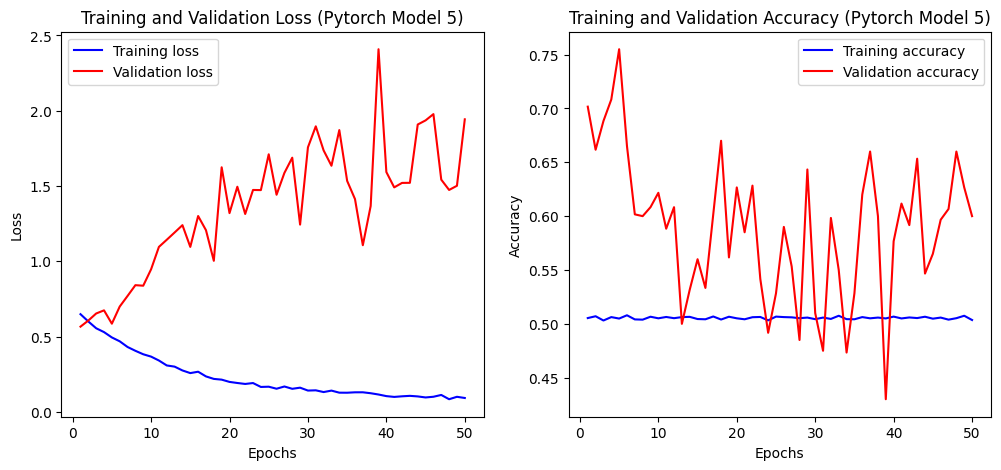

In [107]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))


# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_list_pt5, 'b', label='Training loss')
plt.plot(range(1, num_epochs + 1), val_loss_list_pt5, 'r', label='Validation loss')
plt.title('Training and Validation Loss (Pytorch Model 5)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc_list_pt5, 'b', label='Training accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_list_pt5, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy (Pytorch Model 5)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

In [97]:
# Evaluate the PyTorch model
pytorch_model_5.eval()  # Set the model to evaluation mode
test_running_loss_pt5 = 0.0
test_running_corrects_pt5 = 0
test_total_samples_pt5 = 0
predicted_labels_pt5 = []

with torch.no_grad():  # Disable gradient calculation during evaluation
    for inputs, labels in test_generator:
        # Convert inputs and labels to PyTorch tensors
        inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 3, 1, 2)
        labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

        # Forward pass
        outputs = pytorch_model_1(inputs)
        loss = criterion(outputs, labels)

        test_running_loss_pt5 += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
       
        # Convert predicted probabilities to binary predictions
        binary_predicted_labels_batch = []
        for output in outputs:
            if output >= 0.5:
                binary_predicted_labels_batch.append(1)
            else:
                binary_predicted_labels_batch.append(0)
       
        predicted_labels_pt5.extend(binary_predicted_labels_batch)
        test_running_corrects_pt5 += torch.sum(preds == labels.view(-1)).item()
        test_total_samples_pt5 += inputs.size(0)
        if test_total_samples_pt5 >= len(test_generator.filenames):
            break

# Calculate evaluation metrics
test_loss_pt5 = test_running_loss_pt5 / test_total_samples_pt5
test_accuracy_pt5 = test_running_corrects_pt5 / test_total_samples_pt5

print(f"Test Loss: {test_loss_pt5:.4f}, Accuracy: {test_accuracy_pt5 * 100:.2f}%")

Test Loss: 0.7923, Accuracy: 58.50%


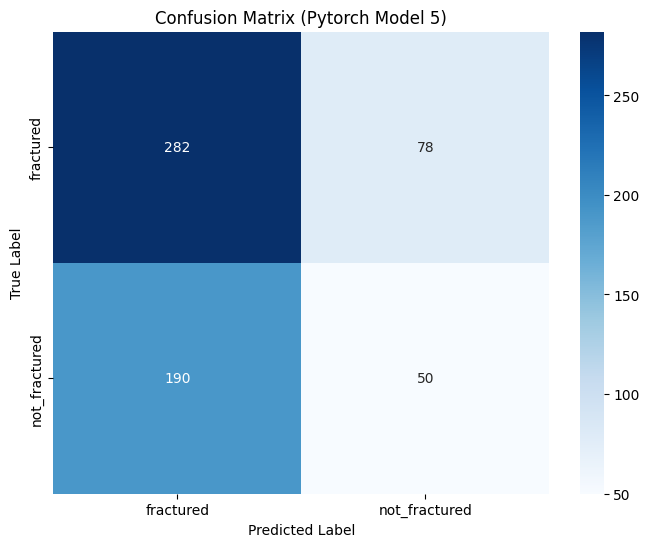

In [138]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_pt5)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Pytorch Model 5)')
plt.show()

In [96]:
print(classification_report(true_labels, predicted_labels_pt5, target_names=test_generator.class_indices.keys()))

               precision    recall  f1-score   support

    fractured       0.61      0.80      0.69       360
not_fractured       0.45      0.25      0.32       240

     accuracy                           0.58       600
    macro avg       0.53      0.52      0.51       600
 weighted avg       0.55      0.58      0.54       600



# Performance Evaluation

In [137]:
# Create a DataFrame
data = {
    "Model": ["TensorFlow Model " + str(i) for i in range(1, 6)] + ["PyTorch Model " + str(i) for i in range(1, 6)],
    "Training Duration (s)": [duration_tf1, duration_tf2, duration_tf3, duration_tf4, duration_tf5, duration_pt1, duration_pt2, duration_pt3, duration_pt4, duration_pt5],
    "CPU Usage (%)": [cpu_usage_tf1, cpu_usage_tf2, cpu_usage_tf3, cpu_usage_tf4, cpu_usage_tf5, cpu_usage_pt1, cpu_usage_pt2, cpu_usage_pt3, cpu_usage_pt4, cpu_usage_pt5],
    "RAM Usage (%)": [ram_usage_tf1, ram_usage_tf2, ram_usage_tf3, ram_usage_tf4, ram_usage_tf5, ram_usage_pt1, ram_usage_pt2, ram_usage_pt3, ram_usage_pt4, ram_usage_pt5]
}

df = pd.DataFrame(data)

# Round the "Training Duration (s)" column to 2 decimal places
df["Training Duration (s)"] = df["Training Duration (s)"].round(2)

# Print the DataFrame
df

,Model,Training Duration (s),CPU Usage (%),RAM Usage (%)
0,TensorFlow Model 1,1576.36,8.0,49.6
1,TensorFlow Model 2,1566.56,7.0,49.9
2,TensorFlow Model 3,1681.77,9.0,50.8
3,TensorFlow Model 4,1749.18,9.7,51.9
4,TensorFlow Model 5,1771.67,8.5,51.5
5,PyTorch Model 1,2276.58,45.2,50.3
6,PyTorch Model 2,3990.91,25.0,61.7
7,PyTorch Model 3,2465.91,45.2,52.1
8,PyTorch Model 4,2601.27,45.9,53.6
9,PyTorch Model 5,2510.54,46.6,51.2


In [140]:
test_data = {
    "Model": ["TensorFlow Model " + str(i) for i in range(1, 6)] + ["PyTorch Model " + str(i) for i in range(1, 6)],
    "Test Loss": [test_loss_tf1, test_loss_tf2, test_loss_tf3, test_loss_tf4, test_loss_tf5, test_loss_pt1, test_loss_pt2, test_loss_pt3, test_loss_pt4, test_loss_pt5],
    "Test Accuracy": [test_accuracy_tf1, test_accuracy_tf2, test_accuracy_tf3, test_accuracy_tf4, test_accuracy_tf5, test_accuracy_pt1, test_accuracy_pt2, test_accuracy_pt3, test_accuracy_pt4, test_accuracy_pt5]
}

test_df = pd.DataFrame(test_data)
test_df["Test Loss"] = test_df["Test Loss"].round(4)
test_df["Test Accuracy"] = test_df["Test Accuracy"].round(4)

# Print the DataFrame
test_df

,Model,Test Loss,Test Accuracy
0,TensorFlow Model 1,0.6554,0.6067
1,TensorFlow Model 2,1.0384,0.6383
2,TensorFlow Model 3,1.3571,0.5800
3,TensorFlow Model 4,0.9324,0.7450
4,TensorFlow Model 5,1.1362,0.7183
5,PyTorch Model 1,0.7623,0.6217
6,PyTorch Model 2,0.7680,0.5950
7,PyTorch Model 3,0.7577,0.6033
8,PyTorch Model 4,0.7937,0.5883
9,PyTorch Model 5,0.7923,0.5850
